# Traveler Salesman Problem

Here is a toy example of the TSP with 52 cities.
The solution proposed is an elitist genetic algorithm with a swap mutation and a 2-points crossover with 2-individuals turnament. Its performances are not great, a lot of improvements can be done.

In [1]:
# IMPORT LIBRARIES 

# basics
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random as rd

## 1. Read & store distances

In [2]:
# IMPORT DATASET
data = pd.read_csv("tsp.csv",header=None)

# BUILD DATAFRAME
df = pd.DataFrame(data=data)
df.columns = ['city_number','x','y']
df.head()

,city_number,x,y
0,1,565,575
1,2,25,185
2,3,345,750
3,4,945,685
4,5,845,655


In [3]:
# COMPUTE & STORE DISTANCES

def fill_dist_matrix():
    x_diff = np.array([np.subtract(df['x'],x_i) for x_i in df['x']])
    y_diff = np.array([np.subtract(df['y'],y_i) for y_i in df['y']])
    return abs(x_diff)+abs(y_diff)

dist = fill_dist_matrix()

Is this matrix correct ? Let's test on the distance city0-->city1 :
 - dist[0,1] is 930
 - and |x1-x0| + |y1-y0| is 930


In [4]:
# FITNESS FUNCTION

def fitness_test(path):
    indices = [(path[i],path[i+1]) for i in range(-1,n-1)]
    return np.array([dist[ind] for ind in indices]).sum()

n = df.shape[0]
path = np.arange(0,n)
np.random.shuffle(path)
print("Demo of the fitness function\nWith this path :\n",path)
print("We have a fitness of :",fitness_test(path))

Demo of the fitness function
With this path :
 [ 1 10 24 27 38 15  4 16 41 35 25 23 13 29 36 32 30  7  8 47 14 48 20 19
  6 46 12 50 33  5 43 44 34 39 17 28  2  0 37 42 22 21 11 18 26 49  3 40
 51 31 45  9]
We have a fitness of : 37960


## 2. Genetic Algorithm

### 2.0 Hyperparameters

In [135]:
pop_size      = 100
mutation_rate = 0.01
generations   = 1000

### 2.1 Individual Class

In [10]:
class Individual:
    
    def __init__(self):
        # random path
        self.genes   = np.arange(0,n)
        np.random.shuffle(self.genes)
        # fitness
        self.fitness = 0
        
    def update_fitness(self):
        # recompute total length
        indices      =  [(self.genes[i],self.genes[i+1]) for i in range(-1,n-1)]
        self.fitness = np.array([dist[ind] for ind in indices]).sum()
        
    def mutate(self):
        for i in range(n):
            if rd.random() < mutation_rate:
                #sometimes swap 2 cities
                ind1            , ind2             = rd.randint(0,n-1) , rd.randint(0,n-1)
                self.genes[ind1], self.genes[ind2] = self.genes[ind2]  , self.genes[ind1] 
    
    def crossover(self, mate):
        # 2 points crossover
        
        # first we take 2 points
        ind1, ind2 = rd.randint(0,n-1) , rd.randint(0,n-1)
        if ind2<ind1 :
            ind1, ind2 = ind2, ind1
            
        # here is our child
        child = Individual()
        
        # we copy-paste the inbetween indices part from mate.genes to child.genes
        child.genes[:ind2-ind1+1] = mate.genes[ind1:ind2+1].copy()
        
        # we complete with the missing genes
        current_index = ind2-ind1+1
        for gene in self.genes:
            if gene not in child.genes[:ind2-ind1+1]:
                child.genes[current_index] = gene
                current_index += 1
        if current_index != n :
            print("wait whut ?")
        
        # is is a good child ?
        child.update_fitness()
        if child.fitness < self.fitness :
            #print("good crossover!")
            self.genes   = child.genes[:]
            self.fitness = child.fitness

### 2.2 Population Class

In [55]:
class Population:
    
    def __init__(self):
        # create pop_size individuals
        self.population = [Individual() for _ in range(pop_size)]
        self.best_path = self.population[0].genes.copy()
        self.best_fitness = np.inf
        
    def update_all_fitness(self):
        # update fitness of each individual
        for i in range(pop_size):
            self.population[i].update_fitness()
            
    def mutate_all(self):
        # try a mutation for each indivual
        # and keep the mutant if it brings an improvment
        for i in range(pop_size):
            mutant = Individual()
            mutant.genes = self.population[i].genes.copy()
            mutant.mutate()
            mutant.update_fitness()
            if mutant.fitness < self.population[i].fitness :
                #print("good mutation!")
                self.population[i].genes   = mutant.genes.copy()
                self.population[i].fitness = mutant.fitness
                
    def crossover_all(self):
        for i in range(pop_size):
            # 2-individuals turnament
            ind1, ind2 = rd.randint(0,n-1) , rd.randint(0,n-1)
            # try a crossover for each indivual
            # and keep the child if it brings an improvment
            if self.population[ind1].fitness < self.population[ind2].fitness:
                self.population[i].crossover(self.population[ind1])
            else :
                self.population[i].crossover(self.population[ind2])
            
            
    def get_best(self):
        # find best individual in the population
        self.best_fitness = self.population[0].fitness
        for i in range(pop_size):
            tmp = self.population[i].fitness
            if tmp < self.best_fitness :
                self.best_fitness = tmp
                self.best_path = self.population[i].genes[:]

### 2.3 Evolution !

In [136]:
def solve():
    
    # INIT POPULATION
    pop= Population()
    pop.update_all_fitness()

    # STATISTICS
    best_fitnesses = []
    
    # EVOLVE
    for generation in range(generations):
        pop.mutate_all()
        pop.update_all_fitness()
        pop.crossover_all()
        pop.update_all_fitness()
        pop.get_best()
        
        if (generation % 10 == 0):
            best_fitnesses.append(pop.best_fitness)
    
    return pop.best_path, pop.best_fitness, best_fitnesses


In [137]:
%%time
best_path, best_fitness, best_fitnesses = solve()

Wall time: 43.6 s


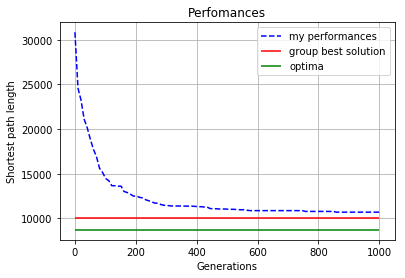

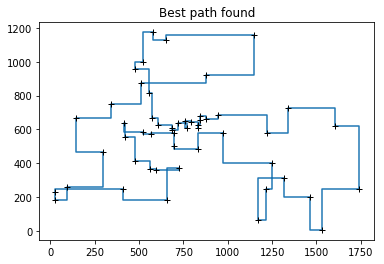

Shortest path length : 10690


In [138]:
def results(best_path, best_fitness, best_fitnesses):
    plt.plot(10*np.linspace(0,len(best_fitnesses), int(generations/10)), best_fitnesses,color='blue',linestyle='--')
    plt.hlines(y=9991,xmin=0,xmax=generations,color='red')
    plt.hlines(y=8700,xmin=0,xmax=generations,color='green')
    plt.xlabel("Generations")
    plt.ylabel("Shortest path length")
    plt.legend(["my performances","group best solution","optima"])
    plt.grid(True)
    plt.title("Perfomances")
    plt.show()
    
    [X,Y] = list(np.array(df)[best_path][:,1:].T)
    plt.step(np.concatenate((X,[X[0]])),np.concatenate((Y,[Y[0]])),where='post')
    plt.plot(X,Y,'s',marker='+',color='black')
    plt.title("Best path found")
    plt.show()
    
    print("Shortest path length :",best_fitness)

results(best_path, best_fitness, best_fitnesses)